In [35]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from itertools import chain, combinations

sns.set()

In [36]:
res = pd.read_csv(
    "data/NEallResults.csv"
)

In [37]:
# Check that the group columns are the same
print(sum([1 if x["Group"].lower() == x["Group2"].lower() else 0 for i, x in res.iterrows()]))
print(res.shape[0])

180
180


In [38]:
res = res.drop(labels=["Group", "Regions"], axis=1)

In [39]:
res.head()

,Species,N,Status,Group2,MLdistance,MLsimilarity,AAdistance,AAsimilarity,ZtestDistance,ZtestSimilarity,Nsdistance,Nssimilarity,PatristicDistance,PatristicSimilarity
0,Camponotus pennsylvanicus,9,native,group_1,0.056518,0.008377,0.009174,0.004669,0.0,0.368472,0.003991,0.002035,0.060167,0.014500
1,Sirex noctilio,10,introduced,group_10,0.093284,0.000000,0.056353,0.000000,0.0,1.000000,0.034120,0.000000,0.100500,0.001000
2,NaN,1,NaN,group_100,0.185581,NaN,0.177548,NaN,0.0,NaN,0.104671,NaN,0.184000,NaN
3,NaN,2,NaN,group_101,0.138241,0.004578,0.075398,0.000000,0.0,0.082645,0.052993,0.000000,0.112500,0.005000
4,Vespula maculifrons,4,native,group_102,0.202992,0.005274,0.182382,0.000000,0.0,0.088132,0.104135,0.000000,0.135500,0.009667


In [40]:
metadata = res.iloc[:, :4] # select data not used for clustering
metadata.head()
data = res.iloc[:, 4:] # select data for clustering
data.head()

,MLdistance,MLsimilarity,AAdistance,AAsimilarity,ZtestDistance,ZtestSimilarity,Nsdistance,Nssimilarity,PatristicDistance,PatristicSimilarity
0,0.056518,0.008377,0.009174,0.004669,0.0,0.368472,0.003991,0.002035,0.060167,0.014500
1,0.093284,0.000000,0.056353,0.000000,0.0,1.000000,0.034120,0.000000,0.100500,0.001000
2,0.185581,NaN,0.177548,NaN,0.0,NaN,0.104671,NaN,0.184000,NaN
3,0.138241,0.004578,0.075398,0.000000,0.0,0.082645,0.052993,0.000000,0.112500,0.005000
4,0.202992,0.005274,0.182382,0.000000,0.0,0.088132,0.104135,0.000000,0.135500,0.009667


In [41]:
data_np = data.to_numpy() # convert to numpy for imputer
# make imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
data_np = imp_mean.fit_transform(data_np)
pd.DataFrame(data_np).head()


,0,1,2,3,4,5,6,7,8,9
0,0.056518,0.008377,0.009174,0.004669,0.0,0.368472,0.003991,0.002035,0.060167,0.014500
1,0.093284,0.000000,0.056353,0.000000,0.0,1.000000,0.034120,0.000000,0.100500,0.001000
2,0.185581,0.002559,0.177548,0.000679,0.0,0.629096,0.104671,0.000290,0.184000,0.004301
3,0.138241,0.004578,0.075398,0.000000,0.0,0.082645,0.052993,0.000000,0.112500,0.005000
4,0.202992,0.005274,0.182382,0.000000,0.0,0.088132,0.104135,0.000000,0.135500,0.009667


In [42]:
scaler = preprocessing.MinMaxScaler()

In [43]:

resnorm = pd.DataFrame(scaler.fit_transform(data_np))
resnorm = pd.concat([metadata, resnorm], axis=1)
resnorm.columns = res.columns
resnorm.head()


,Species,N,Status,Group2,MLdistance,MLsimilarity,AAdistance,AAsimilarity,ZtestDistance,ZtestSimilarity,Nsdistance,Nssimilarity,PatristicDistance,PatristicSimilarity
0,Camponotus pennsylvanicus,9,native,group_1,0.080080,0.472190,0.024540,0.293343,0.0,0.361449,0.015811,0.302313,0.100611,0.537037
1,Sirex noctilio,10,introduced,group_10,0.175632,0.000000,0.150733,0.000000,0.0,1.000000,0.135177,0.000000,0.214386,0.037037
2,NaN,1,NaN,group_100,0.415500,0.144228,0.474906,0.042640,0.0,0.624971,0.414693,0.043098,0.449929,0.159295
3,NaN,2,NaN,group_101,0.292468,0.258041,0.201675,0.000000,0.0,0.072444,0.209952,0.000000,0.248237,0.185185
4,Vespula maculifrons,4,native,group_102,0.460749,0.297275,0.487836,0.000000,0.0,0.077992,0.412567,0.000000,0.313117,0.358025


In [44]:
known = resnorm[resnorm["Status"].notnull()]

In [45]:
def create_kmeans(x, k):
    """Create list of cluster ID's using k-means clustering.

    Args:
        x (ndarray): Data to cluster.
        k (int): number of clusters to make

    Returns:
        array: cluster ID's

    """
    # kmeans = make_pipeline(
    #     StandardScaler().fit_transform(),
    #     KMeans(n_clusters=k)
    # )
    kmeans = KMeans(n_clusters=k)

    return kmeans.fit_predict(x)

In [46]:
known["Cluster"] = create_kmeans(known.iloc[:, 4:], 2)

C:\Users\J C\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [47]:
nmatch1 = known[(known["Status"] == "native") & (known["Cluster"] == 1)].shape[0]
nmatch0 = known[(known["Status"] == "native") & (known["Cluster"] == 0)].shape[0]
imatch1 = known[(known["Status"] == "introduced") & (known["Cluster"] == 1)].shape[0]
imatch0 = known[(known["Status"] == "introduced") & (known["Cluster"] == 0)].shape[0]

nmatch_choice = 1 if nmatch1 > nmatch0 else 0

print("Number of 1's matched to native : {:2d}".format(nmatch1))
print("Number of 0's matched to native : {:2d}".format(nmatch0))
print("Number of 1's matched to introd : {:2d}".format(imatch1))
print("Number of 0's matched to introd : {:2d}".format(imatch0))


Number of 1's matched to native : 20
Number of 0's matched to native : 47
Number of 1's matched to introd :  4
Number of 0's matched to introd :  4


In [48]:
known["Predict"] = ["native" if x == nmatch_choice else "introduced" for x in known["Cluster"]]

C:\Users\J C\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
known["Correct"] = known.apply(lambda row: 1 if row["Status"] == row["Predict"] else 0, axis=1)

C:\Users\J C\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [50]:
print("Accuracy: {:.2f}%".format(100 * known["Correct"].sum() / known["Correct"].shape[0]))

Accuracy: 68.00%


In [51]:
known.head()

,Species,N,Status,Group2,MLdistance,MLsimilarity,AAdistance,AAsimilarity,ZtestDistance,ZtestSimilarity,Nsdistance,Nssimilarity,PatristicDistance,PatristicSimilarity,Cluster,Predict,Correct
0,Camponotus pennsylvanicus,9,native,group_1,0.080080,0.472190,0.024540,0.293343,0.0,0.361449,0.015811,0.302313,0.100611,0.537037,0,native,1
1,Sirex noctilio,10,introduced,group_10,0.175632,0.000000,0.150733,0.000000,0.0,1.000000,0.135177,0.000000,0.214386,0.037037,0,native,0
4,Vespula maculifrons,4,native,group_102,0.460749,0.297275,0.487836,0.000000,0.0,0.077992,0.412567,0.000000,0.313117,0.358025,1,introduced,0
5,Pimpla aequalis,3,native,group_103,0.375581,0.171924,0.338045,0.000000,0.0,0.176708,0.321436,0.000000,0.393512,0.111111,1,introduced,0
12,Sirex cyaneus,1,native,group_11,0.022465,0.144228,0.036894,0.042640,0.0,0.624971,0.023351,0.043098,0.026798,0.159295,0,native,1


In [52]:
known.iloc[:, 4:-3].head()

,MLdistance,MLsimilarity,AAdistance,AAsimilarity,ZtestDistance,ZtestSimilarity,Nsdistance,Nssimilarity,PatristicDistance,PatristicSimilarity
0,0.080080,0.472190,0.024540,0.293343,0.0,0.361449,0.015811,0.302313,0.100611,0.537037
1,0.175632,0.000000,0.150733,0.000000,0.0,1.000000,0.135177,0.000000,0.214386,0.037037
4,0.460749,0.297275,0.487836,0.000000,0.0,0.077992,0.412567,0.000000,0.313117,0.358025
5,0.375581,0.171924,0.338045,0.000000,0.0,0.176708,0.321436,0.000000,0.393512,0.111111
12,0.022465,0.144228,0.036894,0.042640,0.0,0.624971,0.023351,0.043098,0.026798,0.159295


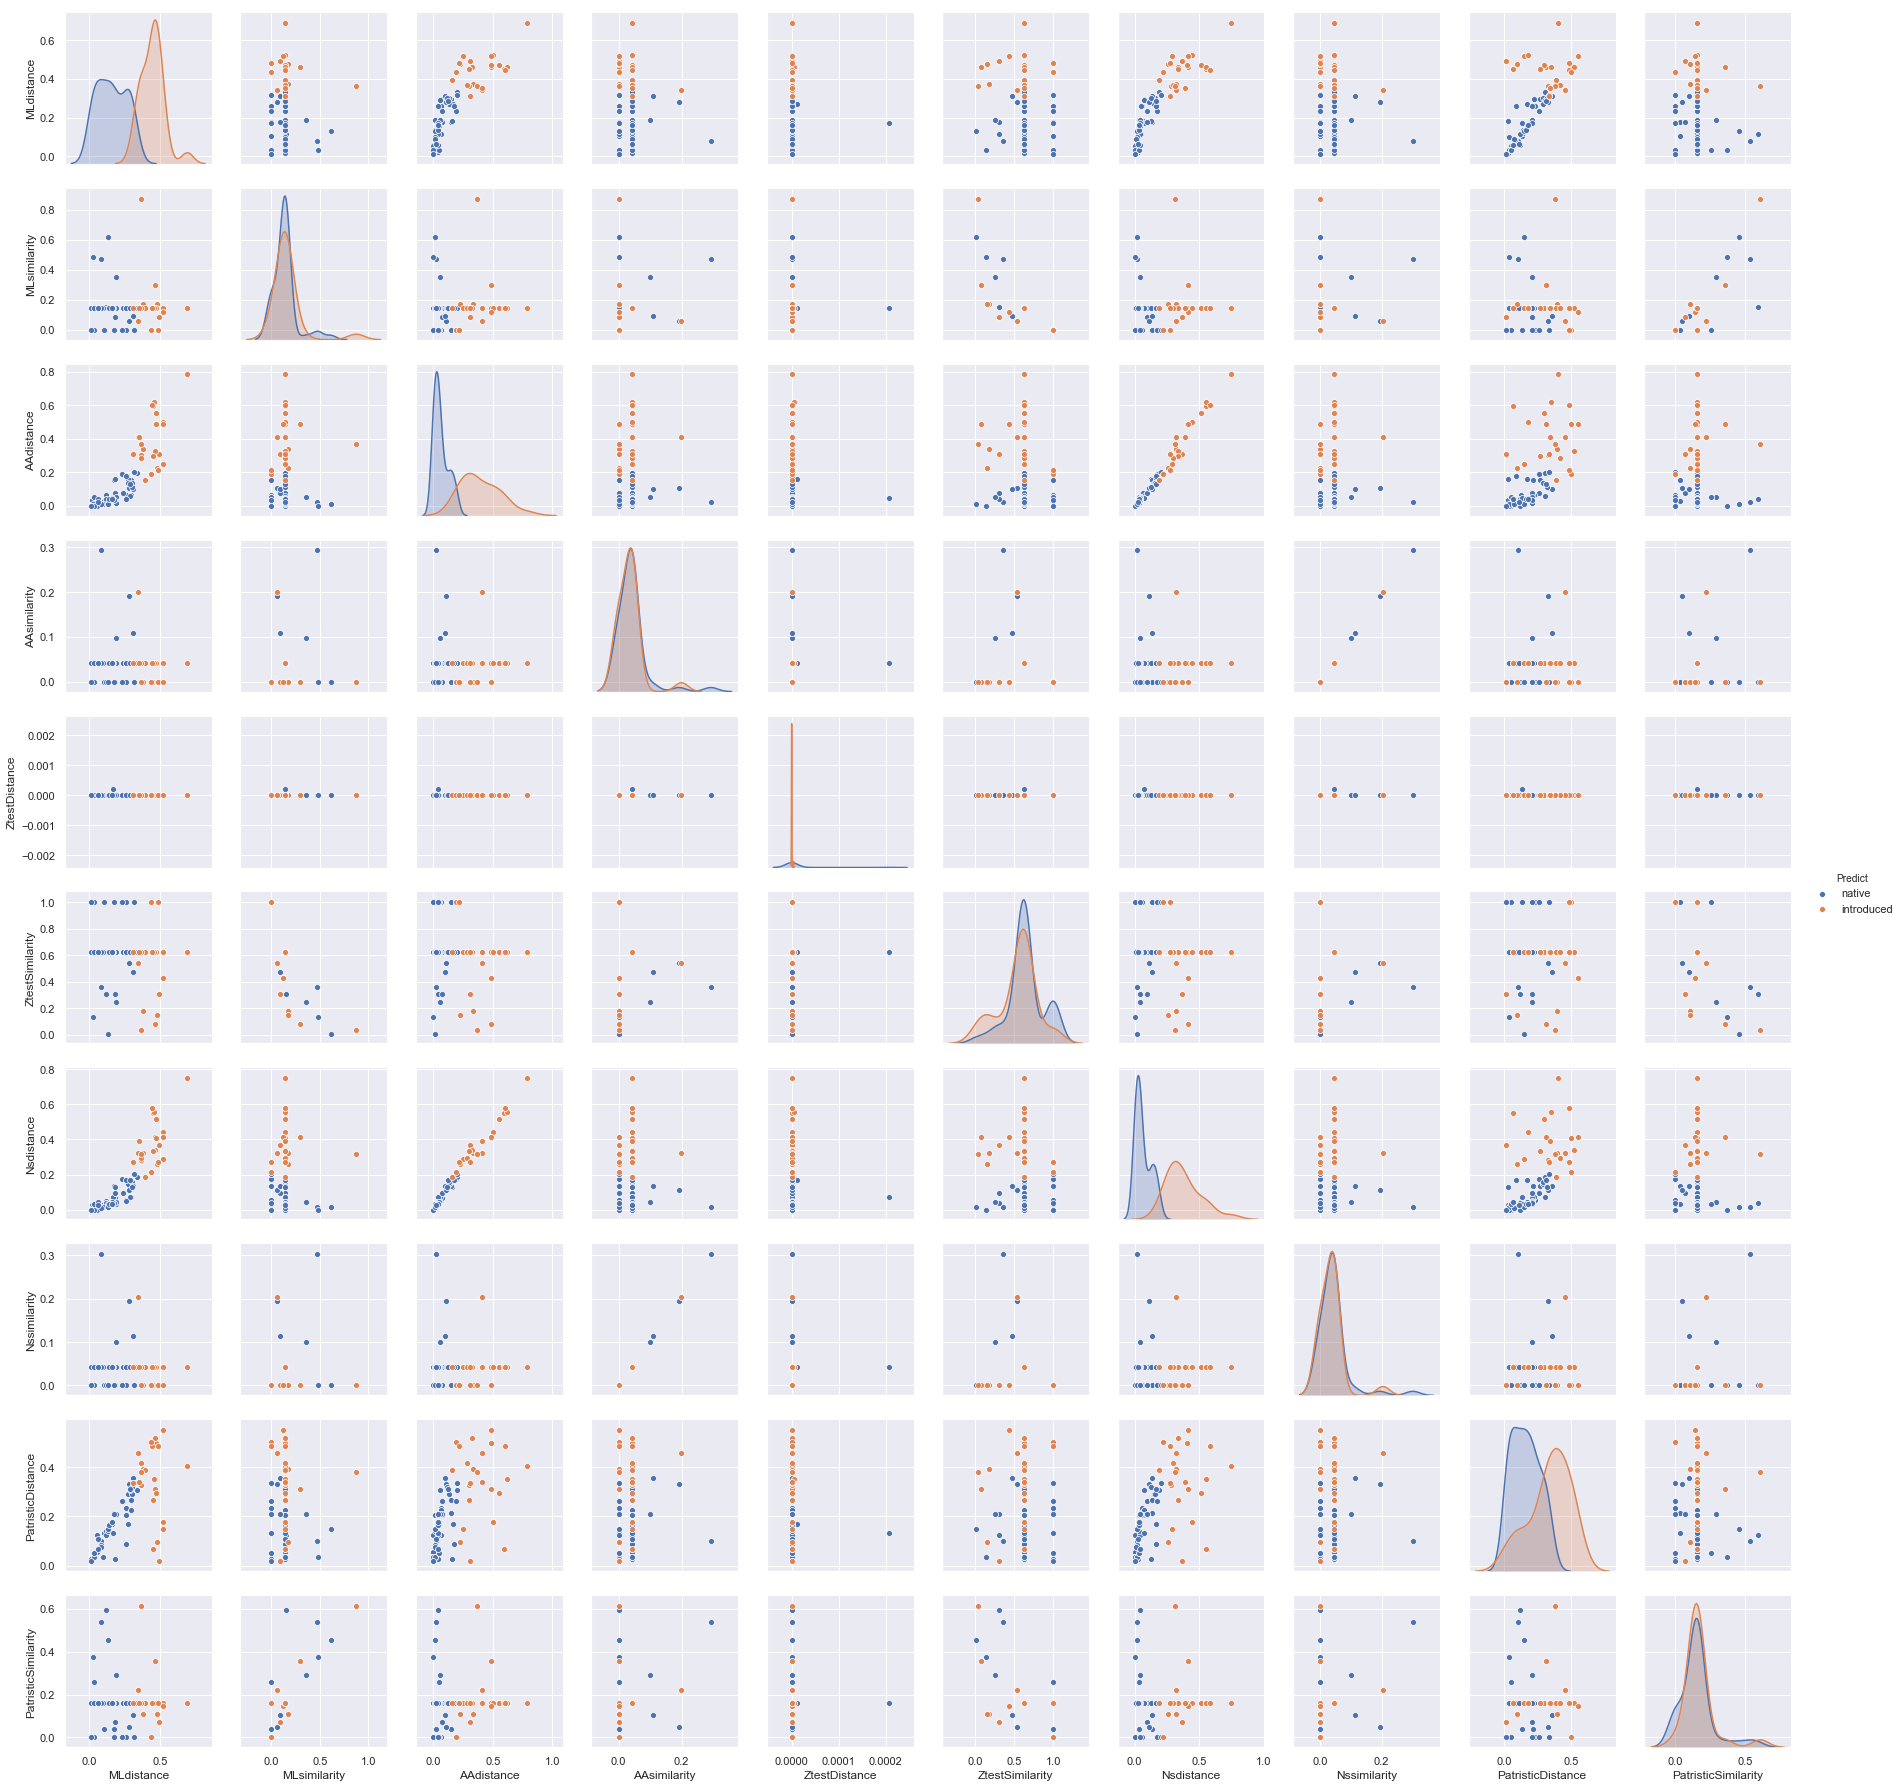

In [53]:
viz = sns.pairplot(
    data=known,
    vars=known.columns[4:-3],
    hue="Predict"
)
viz

In [54]:
nerr = known[(known["Status"] == "native") & (known["Correct"] == 0)].shape[0] / known[known["Status"] == "native"].shape[0] * 100
ierr = known[(known["Status"] == "introduced") & (known["Correct"] == 0)].shape[0] / known[known["Status"] == "introduced"].shape[0] * 100

print("Percent of Native mislabled to Introduced: {:.2f}%".format(nerr))
print("Percent of Introduced mislabled to Native: {:.2f}%".format(ierr))

Percent of Native mislabled to Introduced: 29.85%
Percent of Introduced mislabled to Native: 50.00%


In [55]:
def powerset(iterable):
    # courtesy of itertools documentation
    # modified not to return empty set
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

In [77]:
def kmeans_acc(df):
    test = df
    # print(test.iloc[:, 4:].head())
    test.loc[:, "Cluster"] = create_kmeans(test.iloc[:, 4:], 2)

    nmatch1 = test[(test["Status"] == "native") & (test["Cluster"] == 1)].shape[0]
    nmatch0 = test[(test["Status"] == "native") & (test["Cluster"] == 0)].shape[0]
    imatch1 = test[(test["Status"] == "introduced") & (test["Cluster"] == 1)].shape[0]
    imatch0 = test[(test["Status"] == "introduced") & (test["Cluster"] == 0)].shape[0]

    nmatch_choice = 1 if nmatch1 > nmatch0 else 0
    test.loc[:, "Predict"] = ["native" if x == nmatch_choice else "introduced" for x in test["Cluster"]]
    test.loc[:, "Correct"] = test.apply(lambda row: 1 if row["Status"] == row["Predict"] else 0, axis=1)

    
    
    return 100 * test["Correct"].sum() / test["Correct"].shape[0]


In [98]:
def kmeans_graph(df):
    test = df
    # print(test.iloc[:, 4:].head())
    test.loc[:, "Cluster"] = create_kmeans(test.iloc[:, 4:], 2)

    nmatch1 = test[(test["Status"] == "native") & (test["Cluster"] == 1)].shape[0]
    nmatch0 = test[(test["Status"] == "native") & (test["Cluster"] == 0)].shape[0]
    imatch1 = test[(test["Status"] == "introduced") & (test["Cluster"] == 1)].shape[0]
    imatch0 = test[(test["Status"] == "introduced") & (test["Cluster"] == 0)].shape[0]

    nmatch_choice = 1 if nmatch1 > nmatch0 else 0
    test.loc[:, "Predict"] = ["native" if x == nmatch_choice else "introduced" for x in test["Cluster"]]
    test.loc[:, "Correct"] = test.apply(lambda row: 1 if row["Status"] == row["Predict"] else 0, axis=1)
    
    
    acc = 100 * test["Correct"].sum() / test["Correct"].shape[0]
    nerr = df[(df["Status"] == "native") & (df["Correct"] == 0)].shape[0] / df[df["Status"] == "native"].shape[0] * 100
    ierr = df[(df["Status"] == "introduced") & (df["Correct"] == 0)].shape[0] / df[df["Status"] == "introduced"].shape[0] * 100

    print("Percent of Predictions correct:            {:.2f}%".format(acc))
    print("Percent of Native mislabled to Introduced: {:.2f}%".format(nerr))
    print("Percent of Introduced mislabled to Native: {:.2f}%".format(ierr))

    return sns.pairplot(
    data=df,
    vars=df.columns[4:-3],
    hue="Predict")

In [95]:
def kmeans_err(df):
    test = df
    # print(test.iloc[:, 4:].head())
    test.loc[:, "Cluster"] = create_kmeans(test.iloc[:, 4:], 2)

    nmatch1 = test[(test["Status"] == "native") & (test["Cluster"] == 1)].shape[0]
    nmatch0 = test[(test["Status"] == "native") & (test["Cluster"] == 0)].shape[0]
    imatch1 = test[(test["Status"] == "introduced") & (test["Cluster"] == 1)].shape[0]
    imatch0 = test[(test["Status"] == "introduced") & (test["Cluster"] == 0)].shape[0]

    nmatch_choice = 1 if nmatch1 > nmatch0 else 0
    test.loc[:, "Predict"] = ["native" if x == nmatch_choice else "introduced" for x in test["Cluster"]]
    test.loc[:, "Correct"] = test.apply(lambda row: 1 if row["Status"] == row["Predict"] else 0, axis=1)

    nerr = df[(df["Status"] == "native") & (df["Correct"] == 0)].shape[0] / df[df["Status"] == "native"].shape[0] * 100
    ierr = df[(df["Status"] == "introduced") & (df["Correct"] == 0)].shape[0] / df[df["Status"] == "introduced"].shape[0] * 100

    return [nerr, ierr]

In [79]:
best = []
bestacc = 0

for s in powerset(known.columns[4:-3]):
    testsheet = pd.concat([known.iloc[:, 0:4], known[list(s)]], axis=1)
    # print(testsheet.head())
    acc = kmeans_acc(testsheet)
    if acc > bestacc:
        best = list(s)
        bestacc = acc
print(best)
print(bestacc)    
    

['AAsimilarity']
90.66666666666667


Percent of Predictions correct:            90.67%
Percent of Native mislabled to Introduced: 1.49%
Percent of Introduced mislabled to Native: 75.00%


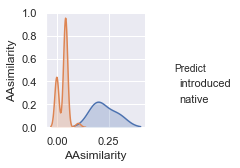

In [99]:
kmeans_graph(pd.concat([known.iloc[:, 0:4], known[best]], axis=1))

In [104]:
best_e = []
besterr = [100, 100]

for s in powerset(known.columns[4:-3]):
    testsheet = pd.concat([known.iloc[:, 0:4], known[list(s)]], axis=1)
    # print(testsheet.head())
    err = kmeans_err(testsheet)
    if np.sum(err) < np.sum(besterr):
        best_e = list(s)
        besterr = err
print(best_e)
print(besterr)   

['PatristicDistance']
[35.82089552238806, 12.5]


Percent of Predictions correct:            66.67%
Percent of Native mislabled to Introduced: 35.82%
Percent of Introduced mislabled to Native: 12.50%


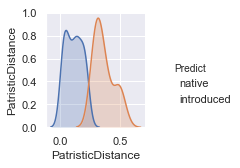

In [105]:
kmeans_graph(pd.concat([known.iloc[:, 0:4], known[best_e]], axis=1))

In [107]:
best_ie = []
bestierr = [100, 100]

for s in powerset(known.columns[4:-3]):
    testsheet = pd.concat([known.iloc[:, 0:4], known[list(s)]], axis=1)
    # print(testsheet.head())
    ierr = kmeans_err(testsheet)
    if ierr[1] < bestierr[1]:
        best_ie = list(s)
        bestierr = ierr
print(best_ie)
print(bestierr) 

['MLdistance']
[47.76119402985074, 12.5]


Percent of Predictions correct:            56.00%
Percent of Native mislabled to Introduced: 47.76%
Percent of Introduced mislabled to Native: 12.50%


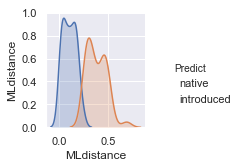

In [108]:
kmeans_graph(pd.concat([known.iloc[:, 0:4], known[best_ie]], axis=1))

In [ ]:
#TODO next up is to try all this again with weighted kmeans, using n for weights. 